In [10]:
import numpy as np
import pandas as pd
import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

### Load Dataset

In [4]:
dataset = pd.read_csv('../dataset/recruitment_data.csv', sep=',', decimal='.')
features = list(dataset.columns.values)
target = features.pop(-1)
# dataset.nunique().sort_values() # Check number of unique values

features.remove('Gender')
features.remove('PreviousCompanies')
features.remove('DistanceFromCompany')
dataset.head()

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,26,1,2,0,3,26.783828,48,78,91,1,1
1,39,1,4,12,3,25.862694,35,68,80,2,1
2,48,0,2,3,2,9.920805,20,67,13,2,0
3,34,1,2,5,2,6.407751,36,27,70,3,0
4,30,0,1,6,1,43.105343,23,52,85,2,0


### Correlation

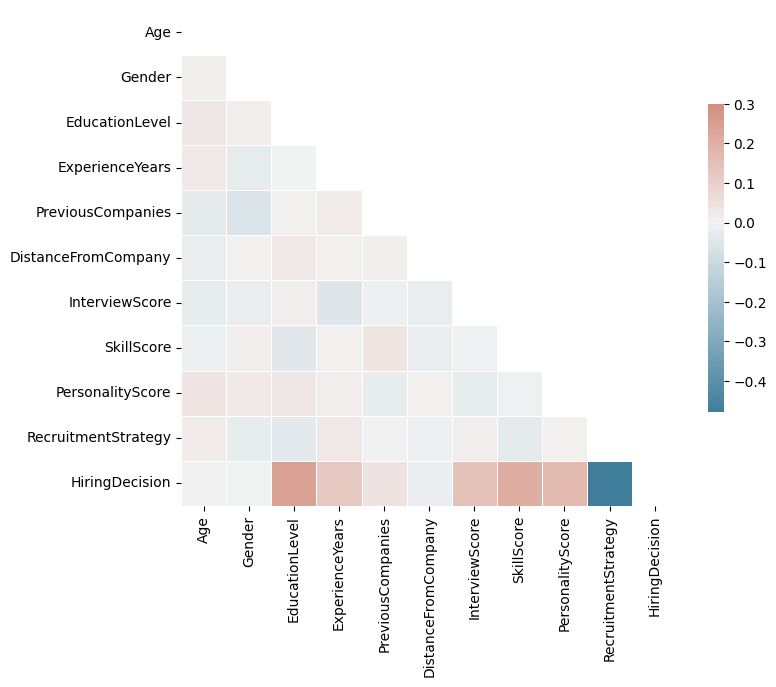

In [5]:
corr = dataset.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype = bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap = True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

### Normalize dataset

In [6]:
X = dataset[features].to_numpy()
Y = dataset[target]

X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X)
X_scaled = X_scaler.transform(X)

Y.head()

0    1
1    1
2    0
3    0
4    0
Name: HiringDecision, dtype: int64

### Training params

In [11]:
max_neurons = 10
f_activation = 'relu' # 'tanh', 'relu', 'sigmoid'
metric = 'Accuracy' # 'Precision', 'Recall', 'Accuracy'
patience = 350
max_epochs = 3 * patience
min_improvement = 0.01
adam_initial_learning_rate = 0.01
adam_learning_rate_decay = 0.99
rollback_on_no_gain = True

# SEED
random_seed = 42
n_k_folds = 3
keras.utils.set_random_seed(random_seed)

# Split data into kfolds
sk_folds = StratifiedKFold(n_splits = n_k_folds)
sk_folds.get_n_splits(X_scaled, Y)

3

### Training

In [12]:
result_list = []

print('TRAINING PROCEDURE STARTED...\n')
for n_neuron in np.arange(1, max_neurons + 1):
    ix_fold = 1
    for train_index, test_index in sk_folds.split(X_scaled, Y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        optimizer = keras.optimizers.Adam(
            learning_rate = adam_initial_learning_rate,
            beta_1 = adam_learning_rate_decay
        )

        model_name = f"ADAM-N{n_neuron}_F{ix_fold}_{target}"
        metric_name = f"val_{metric}"

        inputs = keras.Input(shape=(len(features),))
        hidden_neurons = keras.layers.Dense(n_neuron, activation=f_activation)(inputs)
        outputs = keras.layers.Dense(1, activation='sigmoid')(hidden_neurons) # Binary classification output
        my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

        my_net.compile(optimizer=optimizer, loss = 'mse', metrics = [metric])

        es_loss = keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = patience,
            restore_best_weights = True
        )
        es_metric = keras.callbacks.EarlyStopping(
            monitor = metric,
            mode = 'max',
            patience = patience,
            min_delta = min_improvement,
            restore_best_weights = True
        )

        history = my_net.fit(
            X_train,
            Y_train,
            validation_data = (X_test, Y_test),
            batch_size = X_train.shape[0],
            epochs = max_epochs,
            verbose = 0,
            callbacks = [es_loss, es_metric]
        )

        model_loss = history.history['loss'][-1]
        model_val_loss = history.history['val_loss'][-1]
        metric_val = history.history[metric][-1]
        val_metric_val = history.history[metric_name][-1]
        n_epochs = len(history.history['val_loss'])

        result_dict = {
            'model_name': model_name,
            'optimizer': optimizer,
            'neurons': n_neuron,
            'fold': ix_fold,
            'loss': model_loss,
            'val_loss': model_val_loss,
            metric: metric_val,
            metric_name: val_metric_val,
            'epochs': n_epochs,
            'net': my_net,
            'history': history
        }

        result_list.append(result_dict)

        print('{} > epochs: {} loss: {:.2f} val_loss: {:.2f} {}: {:.0f}% {}: {:.0f}% Activation: {}'.format(model_name, n_epochs, model_loss, model_val_loss, metric,
                100.0 * metric_val, 'val_accuracy', 100.0 * val_metric_val, f_activation))

        maximized_metrics = (val_metric_val == 1.0) & (metric_val == 1.0)
        if maximized_metrics:
            break

        print('')
        ix_fold += 1

best_result = pd.DataFrame(result_list)

TRAINING PROCEDURE STARTED...

ADAM-N1_F1_HiringDecision > epochs: 896 loss: 0.11 val_loss: 0.07 Accuracy: 86% val_accuracy: 91% Activation: relu

ADAM-N1_F2_HiringDecision > epochs: 587 loss: 0.11 val_loss: 0.08 Accuracy: 86% val_accuracy: 89% Activation: relu

ADAM-N1_F3_HiringDecision > epochs: 501 loss: 0.07 val_loss: 0.16 Accuracy: 91% val_accuracy: 80% Activation: relu

ADAM-N2_F1_HiringDecision > epochs: 749 loss: 0.12 val_loss: 0.07 Accuracy: 86% val_accuracy: 90% Activation: relu

ADAM-N2_F2_HiringDecision > epochs: 647 loss: 0.11 val_loss: 0.09 Accuracy: 87% val_accuracy: 89% Activation: relu

ADAM-N2_F3_HiringDecision > epochs: 646 loss: 0.07 val_loss: 0.18 Accuracy: 90% val_accuracy: 78% Activation: relu

ADAM-N3_F1_HiringDecision > epochs: 723 loss: 0.11 val_loss: 0.07 Accuracy: 86% val_accuracy: 91% Activation: relu

ADAM-N3_F2_HiringDecision > epochs: 627 loss: 0.10 val_loss: 0.07 Accuracy: 87% val_accuracy: 90% Activation: relu

ADAM-N3_F3_HiringDecision > epochs: 641 l

Metrics available: ['Accuracy', 'loss', 'val_Accuracy', 'val_loss']


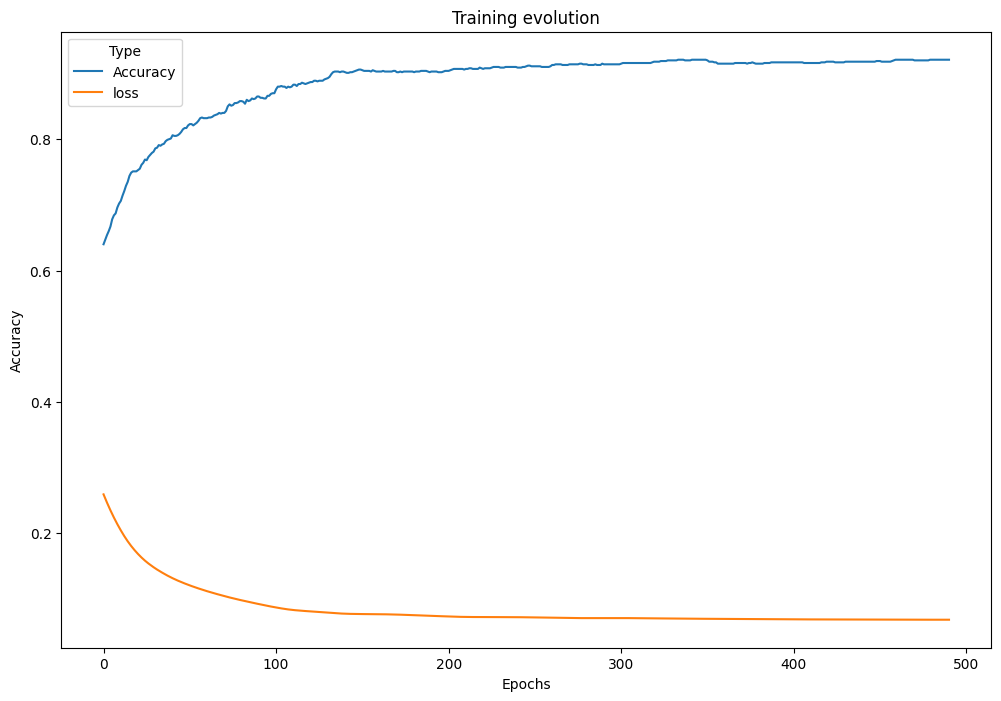

In [9]:
# History data
history_dict = history.history

# Check available keys
available_metrics = list(history_dict.keys())
print("Metrics available:", available_metrics)

plot_data = []

# Check if accuracy and loss keys are available
if 'Accuracy' in available_metrics:
    plot_data.append('Accuracy')
if 'loss' in available_metrics:
    plot_data.append('loss')

if plot_data:
    # Transform data into dataframe
    history_df = pd.DataFrame({key: history_dict[key] for key in plot_data})
    history_df['epoch'] = history_df.index

    history_long = history_df.melt(id_vars='epoch', value_vars=plot_data, 
                                   var_name='Type', value_name='accuracy')

    plt.figure(figsize=(12, 8))
    sns.lineplot(data=history_long, x='epoch', y='accuracy', hue='Type')
    plt.title('Training evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(title='Type')
    plt.show()
else:
    print("No metrics found")